## Импорт необходимых библиотек 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, fbeta_score
from sklearn.preprocessing import MinMaxScaler


# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

*ПРИМЕЧАНИЕ: По какой-то причине, если запускать через Run All, то результаты становятся значительно хуже. Части 3 и 4 рекомендуется обрабатывать последовательно, ячейка за ячейкой, чтобы сохранить результаты.*

## Задача 

В данной рабое будет построена предсказательная модель, определяющую пол клиента по его банковским транзакциям.

Доступны 2 файла:
* __transaction.csv__ - файл с транзакциями, колонки:
    * user_id - целочисленный идентификатор пользователя
    * dt - дата и время совершения транзации, принцип кодирования: "DAY TIME"
        * DAY - порядковый день транзации с начала сбора данных
        * TIME - время в формате hh:mm:ss
    * type - тип (категория) совершаемой транзакции
    * value - сумма транзакции
    
* __gender.csv__ - файл с данными о полах клиентов.
    * user_id - целочисленный идентификатор пользователя
    * gender - целевая переменная, закодированная лейблами 0 и 1. Это сделано:
        * a) для удобства
        * б) для избежания холиваров о правильности исходных меток 

# Часть 1: Минимальная модель

В этой части попробуем построить самую простую модель для предсказания.
Будет проведено простое преобразование данных путём простой агрегации данных о величине транзакций. 

## Загрузка данных

In [2]:
df_GE = pd.read_csv('gender.csv')
df_TR = pd.read_csv('transactions.csv', sep=';')

#посмотрим на данные
df_TR.head()

,user_id,dt,type,value
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099


In [3]:
df_GE.head()

,user_id,gender
0,6740969,1.0
1,36599781,0.0
2,91453656,1.0
3,17431962,1.0
4,72568668,1.0


In [4]:
#объедним в единый df
df = pd.merge(df_TR, df_GE)
df.head()

,user_id,dt,type,value,gender
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099,1.0
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212,1.0
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395,1.0
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099,1.0
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099,1.0


**Проверим на наличие пропусков в данных:**

In [5]:
df.isnull().sum()

user_id    0
dt         0
type       0
value      0
gender     0
dtype: int64

### Агрегация 

Произведём простую агрегацию данных и для каждого пользователя в качестве признаков получим сумму, среднее и стандартное отклонение величины его транзакций. 
Так же добавим для каждого пользователя колонку с таргетом.

По итогу мы должны получить таблицу с колонками:
* user_id
* value_sum
* value_mean
* value_std
* gender

In [6]:
df1 = df.copy(deep=True)
df1 = df1.groupby(by=['user_id']).agg(value_sum=('value', np.sum),
                                     value_mean=('value', np.mean),
                                     value_std=('value', np.std),
                                     gender=('gender', np.min))
df1.head()

,value_sum,value_mean,value_std,gender
user_id,,,,
22899,274383.315,2143.619648,656.186785,1.0
27914,166436.523,2521.765500,415.972053,1.0
28753,251578.185,1980.930591,749.304999,0.0
31385,717856.052,2323.158744,632.491585,0.0
38084,1360028.958,2095.576206,649.030870,0.0


**Проверим на наличие пропусков в данных:**

In [7]:
df1.isnull().sum()

value_sum      0
value_mean     0
value_std     47
gender         0
dtype: int64

Нули в стандартном отклонении встречаются - заполним их нулями. Если там одно значение, то отклонение нулевое.

In [8]:
df1.fillna(0, inplace=True)
df1.isnull().sum()

value_sum     0
value_mean    0
value_std     0
gender        0
dtype: int64

### Отложенная выборка 

Получим полный список пользователей и разделим их на два списка:
* тренировочный список пользователей (80%)
* тестовый список пользователей (20%)

In [9]:
df1_train, df1_test = train_test_split(df1, test_size = 0.2, random_state=40) # делим в пропорции 80 к 20

Для нашей задачи получим признаки и целевые метки обучающей и тестовой выборки. 

In [10]:
y_train = df1_train['gender'].to_numpy()  
y_test = df1_test['gender'].to_numpy()

x_train = df1_train.drop('gender', axis=1).to_numpy()
x_test = df1_test.drop('gender', axis=1).to_numpy()

feature_names1 = df1_train.drop('gender', axis=1).columns

## Обучение и оценка модели

Обучим модель логистической регрессии с дефолтными параметрами.

Получим предсказания вероятностей первого класса.

In [11]:
#обучаем модель
LG = LogisticRegression()
LG.fit(x_train, y_train)

#прогноз вероятности первого класса
p_pred = LG.predict_proba(x_test)[:, 1]
print(f'Прогноз по всей выборке: {p_pred}')
print(f'Средний прогноз: {p_pred.mean()}')

Прогноз по всей выборке: [0.49473942 0.43485618 0.40897428 ... 0.47203794 0.42046731 0.43599846]
Средний прогноз: 0.4378477032006456


### Валидация 

Посчитаем ROC_AUC, accuracy, precision, recall для получившихся предсказаний.

Для метрик, для которых необходимы метки классов, а не вероятности - используем порог 0.5.

Далее при оценки других моделей будем приводить эти же метрики, если явно не потребуется иное.

In [12]:
t = 0.5
y_pred = 1*(p_pred >= t) 

**ROC_AUC:**

In [13]:
roc_auc_score(y_test, p_pred)

0.5476287990159096

Еще нарисуем картинку, чтобы понимать графический результат.

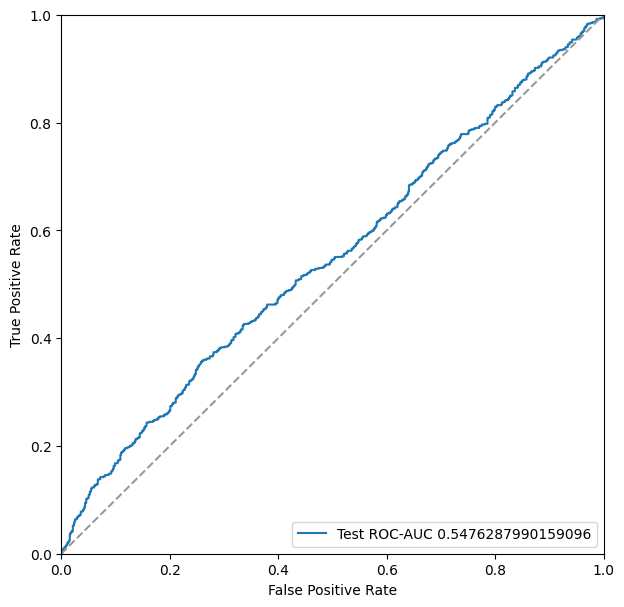

In [14]:
def roc_auc_pic(y_test, p_pred):
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
roc_auc_pic(y_test, p_pred)

Площадь под roc-auc - доля верно классифицированных пар объектов. 


**Доля верно классифицированных объектов (Accuracy):**

In [15]:
accuracy_score(y_test, y_pred)

0.5364832535885168

В разных ситуациях ошибки имеют разные цены. Accurancy не видит этого, поэтому воспользуемся precision и recall.

**Точность (precision):**

In [16]:
precision_score(y_test, y_pred)

0.6153846153846154

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку.

**Полнота (Recall):**

In [17]:
recall_score(y_test, y_pred)

0.020486555697823303

Показывает, как много объектов первого класса наш алгоритм находит, то есть метрика демонстрирует способность алгоритма обнаруживать данный класс вообще.

### Вывод

Модель близка к случайному назначению гендера, что очень плохо и едва ли отличается от подбрасывания монетки.
Причина подобного качества состоит в том, что у модели для анализа было только значение суммы трат, которое не даёт никаких отличий между пользователями и не позволяет делить их на категории. К тому же сумма трат, в отличие от категорий трат, едва ли может что-то сказать о гендере пользователя.
Вторая причина состоит в том, что параметры модели не оптимизированы и она работает на стандартных параметрах.

Иными словами:
1) Плохая предобработка данных
2) Не заданы параметры модели

# Часть 2: Переподготовка данных

Давайте попробуем улучшить качество решения задачи за счёт другого метода подготовки данных.

Ранее мы использовали простое преобразование, когда каждый клиент описывался только 3 значениями.
Давайте сделаем что-то более сложное и попробуем добавить больше данных о клиенте для модели.

## Подготовка данных

Воспользуемся тем, что каждая транзакция у нас имеет свой тип - это уж точно более информативно, чем агрегация по всем транзакциям.

Создадим сводную таблицу, где для каждого клиента (строка) будут указаны его суммарные траты на каждую категорию (столбец). Таким образом, мы должны получить таблицу с числом строк равным количеству клиентов и числом столбцов - количеству категорий трат. Каждая ячейка должна содержать суммарные траты данного клиента в данной категории.

In [18]:
df2 = pd.pivot_table(df, values='value', index=['user_id', 'gender'],
                       columns=['type'], aggfunc=np.sum, fill_value=0)
df2.reset_index(inplace=True)
df2.set_index('user_id', inplace=True, drop=True)
df2.head()

type,gender,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение и валидация модели

Аналогично предыдущей части разделим данные на обучающую и тестовую выборку (80%/20%), обучим модель на дефолтных параметрах и оценим качество.

In [19]:
df2_train, df2_test = train_test_split(df2, test_size = 0.2, random_state=40) # делим в пропорции 80 к 20

In [20]:
y_train = df2_train['gender'].to_numpy()
y_test = df2_test['gender'].to_numpy()

x_train = df2_train.drop('gender', axis=1).to_numpy()
x_test = df2_test.drop('gender', axis=1).to_numpy()

feature_names2 = df2_train.drop('gender', axis=1).columns

In [21]:
#обучаем модель
LG = LogisticRegression()
LG.fit(x_train, y_train)

#прогноз вероятности первого класса
p_pred = LG.predict_proba(x_test)[:, 1]
print(f'Прогноз по всей выборке: {p_pred}')
print(f'Средний прогноз: {p_pred.mean()}')

Прогноз по всей выборке: [0.94331167 0.89520106 0.13679166 ... 0.77782491 0.70489909 0.78218924]
Средний прогноз: 0.46816829674542965


In [22]:
t = 0.5
y_pred = 1*(p_pred >= t)

In [23]:
print('ROC_AUC:', roc_auc_score(y_test, p_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

ROC_AUC: 0.8103865515303842
Accuracy: 0.7392344497607656
Precision 0.757847533632287
Recall: 0.649167733674776


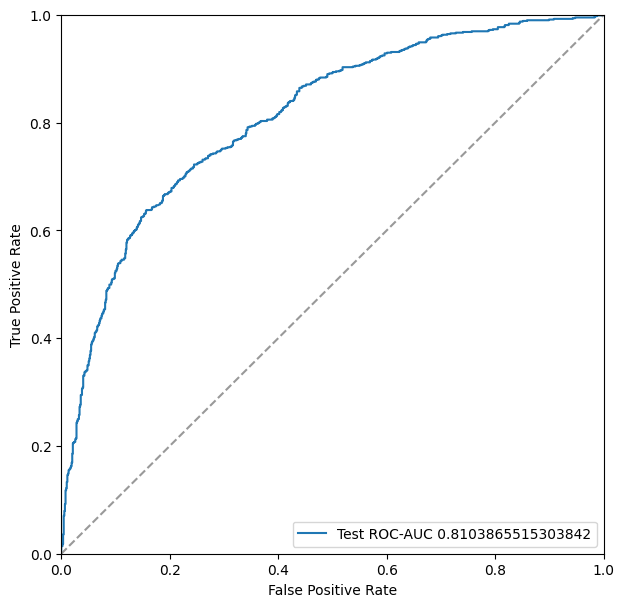

In [24]:
def roc_auc_pic(y_test, p_pred):
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

roc_auc_pic(y_test, p_pred)

### Вывод 

Качество модели значительно улучшилось.
В частности использование в качестве данных категории трат и суммы трат в них, позволяет разделить пользователей по данных категориям и находить общие черты по тратам именно в категориях. Соответственно, классы пользователей итмеют между собой какие-то общие категории трат, которые позволяют предположить их гендер. В качестве недостатка, можно предположить, что сумма трат не важна и без неё точность была бы ещё выше.

Иными словами, на улучшение работы модели повлияла правильная предобработка данных, увеличившая количество признаков.

# Часть 3: Улучшение модели

Ранее мы работали только над подготовкой обучающей выборки. Давайте теперь попробуем изменить модель, чтобы добиться наилучшего качества. 

Входные данные для этой части - выборка с предыдущей.

## Нормирование данных

Как мы знаем, линейные модели любят нормированные данные.

Приведём значения всех признаков в отрезок [0, 1]

In [55]:
df3 = df2.copy(deep=True)
min_max_scaler = MinMaxScaler()
df3 = pd.DataFrame(min_max_scaler.fit_transform(df3), columns=df3.columns, index=df3.index)
df3.head()

type,gender,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Подбор параметров

Подбериём наилучшие параметры для модели линейной регрессии. Важные уточнения:

* используем перебор по сетке
* в качестве метрики используем ROC AUC
* для оценки параметров делаем кросс-валидацию на 4 фолдах

In [56]:
df3_train, df3_test = train_test_split(df3, test_size = 0.2, random_state=40) # делим в пропорции 80 к 20

y_train = df3_train['gender'].to_numpy()
y_test = df3_test['gender'].to_numpy()

x_train = df3_train.drop('gender', axis=1).to_numpy()
x_test = df3_test.drop('gender', axis=1).to_numpy()

feature_names3 = df3_train.drop('gender', axis=1).columns

In [57]:
# подберём solver
param_grid = {
    'solver': ['lbfgs','liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

LG = LogisticRegression()
GS = GridSearchCV(LG, param_grid, cv=4, scoring='roc_auc')
GS.fit(x_train, y_train)

print("Лучший параметр: ", GS.best_params_)
print("Лучший результат: ", GS.best_score_)

Лучший параметр:  {'solver': 'liblinear'}
Лучший результат:  0.7794228231225228


In [59]:
# В качестве оптимального solver выдаёт liblinear, потому подберём параметры для него

param_grid = {
    'penalty': ['l1','l2'],
    'tol': [0.0001, 0.001, 0.01, 0.1, 1, 5],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 50, 100, 500, 1000]
}

LG = LogisticRegression(solver='liblinear')
GS = GridSearchCV(LG, param_grid, cv=4, scoring='roc_auc')
GS.fit(x_train, y_train)

print("Лучшие параметры: ", GS.best_params_)
print("Лучший результат: ", GS.best_score_)

Лучшие параметры:  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.1}
Лучший результат:  0.7956251190410902


Вышли следующие результаты:
C = 1
max_iter = 100
penalty = l1
tol = 0.1

In [68]:
#обучаем модель gо заданным параметрам
LG = LogisticRegression(solver='liblinear', C=1, max_iter=100, penalty='l1', tol=0.1)
LG.fit(x_train, y_train)

#прогноз вероятности первого класса
p_pred = LG.predict_proba(x_test)[:, 1]
print(f'Прогноз по всей выборке: {p_pred}')
print(f'Средний прогноз: {p_pred.mean()}')

Прогноз по всей выборке: [0.84620366 0.84581729 0.23600648 ... 0.68573042 0.68634473 0.47584648]
Средний прогноз: 0.4416798421992695


Оценим качество лучшей модели на тестовых данных аналогично предыдущим задачам.

In [70]:
t = 0.5
y_pred = 1*(p_pred >= t)

In [69]:
print('ROC_AUC:', roc_auc_score(y_test, p_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

ROC_AUC: 0.8084134846832243
Accuracy: 0.7003588516746412
Precision 0.8111111111111111
Recall: 0.4673495518565941


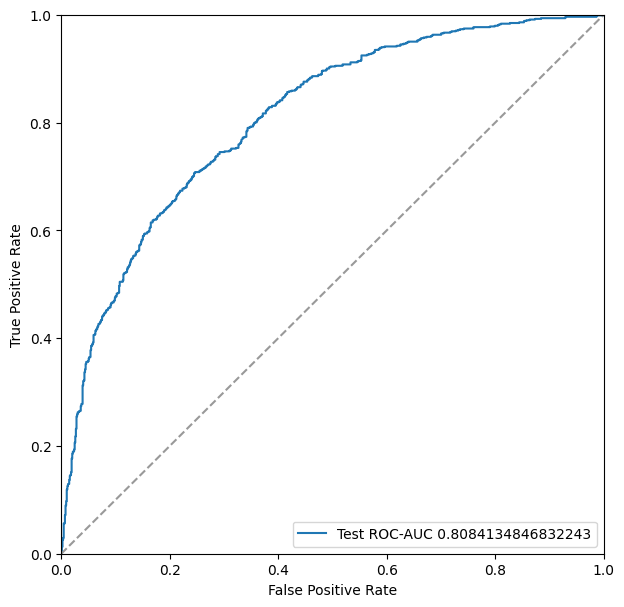

In [71]:
def roc_auc_pic(y_test, p_pred):
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

roc_auc_pic(y_test, p_pred)

Поднять качесто модели не удалось. В зависимости от итерации, качество либо незначительно выше, либо даже ниже.
Скорее всего дело в том, что:
1) За счёт нормализации датасета мы значительно облегчили работу модели, но это не сказалось на качестве категоризации.
2) За счёт подбора параметров, нам удалось найти наиболее подходящие параметры для наших целей и данных, но влияние на эффективность и точность определения связь между категорями трат и гендером пользователей это не улучшило.
3) В нашем кейсе обработка и подготовка данных имеет большее значение, чем подбор параметров.

Использование кросс-валидации и отложенной тестовой выборки позволило проверить каждый набор параметров в нескольких комбинациях данных, что делает результат более зависимым от алгоритма машинного обучения, нежели от выборки данных.

## Подбор отсечения

Ранее мы работали или с вероятностями из модели или с метками, полученных при отсечении по веростности с порогом 0.5.

Стоит сказать, что порог 0.5 для разделения классов не всегда самый лучший. Часто нам нужно так подобрать порог, чтобы удовлетворить наши требования по точности и полноте.

Давайте подберём порог, который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности.

Вычислим наилучший порог и нарисуем график зависимости этой метрики от порога разделения.

0.25000000000000006 0.9581917704794262


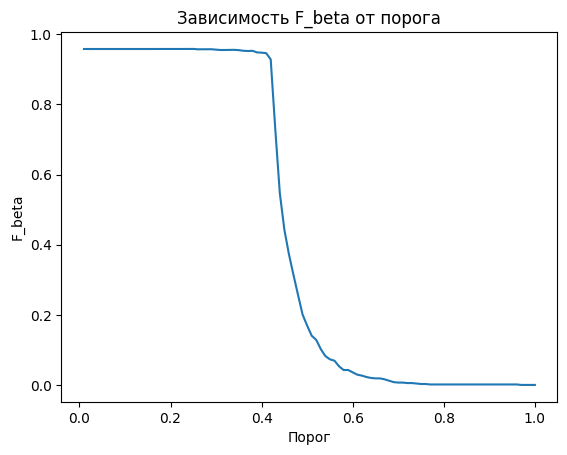

In [33]:
t = 0
best_t = 0
best_res = 0

arr_y = []
arr_x = []

for i in range(0, 100):
    t += 0.01
    y_pred = 1*(p_pred >= t)
    score = fbeta_score(y_test, y_pred, beta=5)
    arr_y.append(score)
    arr_x.append(t)
    if score > best_res:
        best_res = score
        best_t = t

def show_f_beta(x_axis, y_axis):
    plt.plot(x_axis, y_axis)
    plt.title('Зависимость F_beta от порога')
    plt.xlabel('Порог')
    plt.ylabel('F_beta')
    plt.show()

print(best_t, best_res)
show_f_beta(arr_x, arr_y)

Если мы задаём, что полнота нам в пять раз важнее точности, то наилучшим порогом будет минимальный.
В данном случае это значение 0.05

# Часть 4: Попробуем добиться лучших результатов

Так как выяснилось, что при применении логической регрессии, в нашем кейсе подготовка данных имеет большее значение, чем подбор параметров, было решено перевести весь формат таблицы в бинарные данные, поскольку мной было предположено что сумма трат имеет не такое большое значение, как категории трат.
 Как пример такой логикик: в данном случае наиболее вероятно, что один из гендеров будет более склонен тратиться на женскую косметику. И сумма трат значения не имеет.
 Так же это позволяет уменьшить влияние каких-то общих категорий, на пример трат в магазинах общего назначения.

Что же касается подбора параметров модели, то в данном случае был проведен повторый подбор всех параметров из очень большого набора вариантов, что потребовало много времени и вычислительных мощностей, потому было решено эту часть из кода убрать (она занимала десятки минут работы).

In [80]:
df4 = df2.copy(deep=True)
df4[df4 != 0] = 1
df4.head()

type,gender,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
df4_train, df4_test = train_test_split(df4, test_size = 0.2, random_state=40) # делим в пропорции 80 к 20

y_train = df4_train['gender'].to_numpy()
y_test = df4_test['gender'].to_numpy()

x_train = df4_train.drop('gender', axis=1).to_numpy()
x_test = df4_test.drop('gender', axis=1).to_numpy()

feature_names4 = df4_train.drop('gender', axis=1).columns

In [82]:
#обучаем модель
LG = LogisticRegression(solver='newton-cholesky', C=0.1, max_iter=10, penalty='l2', tol=0.000001)
LG.fit(x_train, y_train)

#прогноз вероятности первого класса
p_pred = LG.predict_proba(x_test)[:, 1]
print(f'Прогноз по всей выборке: {p_pred}')
print(f'Средний прогноз: {p_pred.mean()}')

Прогноз по всей выборке: [0.14641571 0.86657322 0.12453656 ... 0.90316545 0.9732032  0.60088428]
Средний прогноз: 0.44174010136468644


In [83]:
# Воспользуемся подобранным ранее значением порога для максимизации f_beta
t = 0.05
y_pred = 1*(p_pred >= t)

In [84]:
print('ROC_AUC:', roc_auc_score(y_test, p_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

ROC_AUC: 0.8480436747615578
Accuracy: 0.5418660287081339
Precision 0.5048543689320388
Recall: 0.998719590268886


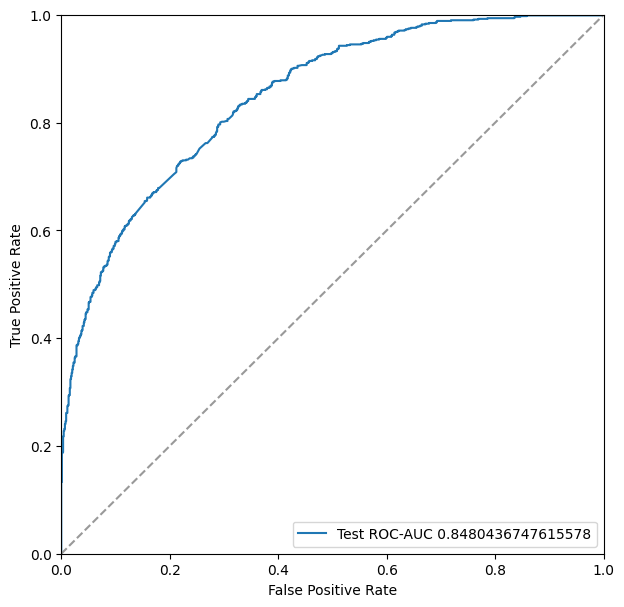

In [86]:
def roc_auc_pic(y_test, p_pred):
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

roc_auc_pic(y_test, p_pred)

# Итоговый результат составил roc_auc = 0.85*
*при округлении до двух знаков